In [1]:
pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchsummary 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as v2
# Import tqdm for progress bar
from tqdm.auto import tqdm
import matplotlib
import matplotlib.pyplot as plt
import cv2
from typing import Any, Callable, List, Optional, Tuple, Union
from torchvision.datasets import CocoDetection
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassJaccardIndex

import pytorch_lightning as pl

# from pytorch_lightning.core.lightning import LightningModule

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_target_image(img, targets, idx):
    
    numpy_img = np.array(img) 
    cv_img = cv2.cvtColor(numpy_img, cv2.COLOR_RGB2BGR) 

    h, w = cv_img.shape[0], cv_img.shape[1]
    #print(h, w)
    # Создать пустое изо бражение
    zero_image = np.zeros((h, w, 1), dtype=np.uint8)
    # Создать пустое изображение

    def fillPolygons(image, mask, categoru_id):
        """
        Рисование многоугольника на изображении
        """
        polygon = np.array(mask,  np.int32 ) 
        cv2.fillPoly(image, pts=[polygon],
                 color=(category_id) 
                       # random.randint(0, 255),
                       # random.randint(0, 255))
                )
                               
                               
    for target_num, target in enumerate(targets) :
        try:
            mask = target['segmentation'][0]
        except KeyError as e:
        # Обработка ошибки
            #print(f"Ошибка при обработке элемента {idx}, {target_num}: {e}")
            continue  # Продолжить выполнение цикла
        category_id = target['category_id']
        new_mask = []
        # преобразуем список координат в нормальные координаты полигона
        for i in range(0, len(mask)-1, 2) :
            x = mask[i]
            y = mask[i+1]
            new_mask. append((x, y)) 
        
        fillPolygons(zero_image, new_mask, category_id)

    # Преобразовать цветовое пространство из BGR в RGB
    
    image_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    return zero_image

In [6]:
class CustomDataset(CocoDetection):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
     
       
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, index) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        image = self._load_image(id)
        target = self._load_target(id)
        target = get_target_image(image, target,  id) 
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        return image, target
        
# Использование
#dataset = CustomDataset(data, targets)


In [7]:
im_size = 128
valid_transforms = v2.Compose(
    [v2.ToImage(), 
     v2.ToDtype(torch.float32, scale=True) , 
    v2.Resize(size=(im_size, im_size), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_target_transforms = v2.Compose(
    [v2.ToImage(), 
     v2.ToDtype(torch.long) , 
     v2.Resize(size=(im_size, im_size), antialias=True),
])

train_transforms = v2.Compose(
    [v2.ToImage(), 
     v2.ToDtype(torch.float32, scale=True) , 
     v2.Resize(size=(im_size, im_size), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_target_transforms = v2.Compose(
    [v2.ToImage(), 
     v2.ToDtype(torch.long) , 
     v2.Resize(size=(im_size, im_size), antialias=True),
])


In [8]:
valid_dataset = CustomDataset(root='/kaggle/input/coco-2017-dataset/coco2017/val2017',
                             annFile='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json',
                             transform=valid_transforms,
                             target_transform=valid_target_transforms)


train_dataset = CustomDataset(root='/kaggle/input/coco-2017-dataset/coco2017/train2017',
                        annFile='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json',
                        transform=train_transforms,
                        target_transform=train_target_transforms)


loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=23.98s)
creating index...
index created!


In [9]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4, pin_memory=True) 

valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=4, pin_memory=True) 

In [10]:
for _, labels in valid_loader:
    n_classes = 100
    bs, h, w= labels.size(0), labels.size(2), labels.size(3) 
    print(labels.shape) 
    print(bs, h, w) 
    labels = labels.squeeze(1) 
    print(labels.shape) 
    preds = torch.rand(bs, n_classes, h, w, dtype=torch.float32) 
    print(preds.shape) 
    metric = MulticlassJaccardIndex(num_classes=n_classes)
    score= metric(preds, labels)
    print(score) 
    break

torch.Size([20, 1, 128, 128])
20 128 128
torch.Size([20, 128, 128])
torch.Size([20, 100, 128, 128])
tensor(0.0013)


# Создаём модель

In [11]:
def conv3x3_plus_conv3x3(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )
        

In [12]:
def conv1x1_plus_conv1x1(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )
        

In [13]:
class CocoModel(nn.Module):
    def __init__(self, base_channels: int = 32,
                num_classes: int = 88,
                block = conv3x3_plus_conv3x3):
        super().__init__()
        '''
        im_size = 256 x N
        in_chan = 32
        '''
        
        
        self.down_1 = block(in_channels=3, out_channels=base_channels) 
        
        self.down_2 =block(in_channels=base_channels, out_channels=base_channels*2) 
                
        self.down_3 = block(in_channels=base_channels*2, out_channels=base_channels*4) 
                
        #self.down_4 = block(in_channels=base_channels*4, out_channels=base_channels*8) 
        
        
        self.bottleneck = conv1x1_plus_conv1x1(in_channels=base_channels*4, out_channels=base_channels*4)
        
        
       # self.up_4 = block(in_channels=base_channels*16, out_channels=base_channels*4) 
        
        self.up_3 = block(in_channels=base_channels*8, out_channels=base_channels*2) 
                
        self.up_2 = block(in_channels=base_channels*4, out_channels=base_channels) 
                
        self.up_1 = block(in_channels=base_channels*2, out_channels=base_channels) 
                
        self.fs = conv3x3_plus_conv3x3(in_channels=base_channels, out_channels=num_classes)
        
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x) :
        #x.shape = N x N x 3
        
        residual_1 = self.down_1(x) #N x N x b_ch
        
        x = self.downsample(residual_1)# N / 2 x N / 2 x b_ch
        
        residual_2 = self.down_2(x) #N / 2 x N / 2 x b_ch*2
        
        x = self.downsample(residual_2) #N / 4 x N / 4 x b_ch*2
        
        residual_3 = self.down_3(x) #N / 4 x N / 4 x b_ch*4
        
        x = self.downsample(residual_3) #N / 8 x N / 8 x b_ch*4
        
       # residual_4 = self.down_4(x) #N / 8 x N / 8 x b_ch*8
        
       # x = self.downsample(residual_4)  #N / 16 x N / 16 x b_ch*8
        
        x = self.bottleneck(x) #N / 16 x N / 16 x b_ch*8
#         print('bottle:', x.shape)
        
     #   x = nn.functional.interpolate(x, scale_factor=2) #N / 8 x N / 8 x b_ch*8
#         print('int_1:', x.shape)

      #  x = torch.cat((x, residual_4), dim=1) #N / 8 x N / 8 x b_ch*16
#         print('cat_1', x.shape)

     #   x = self.up_4(x) #N / 8 x N / 8 x b_ch*4
        
        x = nn.functional.interpolate(x, scale_factor=2) #N / 4 x N / 4 x b_ch*4
        
        x = torch.cat((x, residual_3), dim=1) #N / 4 x N / 4 x b_ch*8
        
        x = self.up_3(x) #N / 4 x N / 4 x b_ch*2
        
        x = nn.functional.interpolate(x, scale_factor=2) #N / 2 x N / 2 x b_ch*2
        
        x = torch.cat((x, residual_2), dim=1) #N / 2 x N / 2 x b_ch*4
        
        x = self.up_2(x) #N / 2 x N / 2 x b_ch
        
        x = nn.functional.interpolate(x, scale_factor=2) #N x N x b_ch
        
        x = torch.cat((x, residual_1), dim=1) #N x N x b_ch*2
        
        x = self.up_1(x) #N x N x b_ch
        
        out = self.fs(x)
        
        return out
        

In [14]:
from torchsummary import summary 

fmodel = CocoModel().to(device)
print('init model') 
summary(fmodel, (3, im_size, im_size)) 

'''
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cifar')

writer.add_graph(fmodel,  torch.randn(1, 3, im_size, im_size).to(device))
writer.close()
'''

init model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         LeakyReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        LeakyReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14        

'\nfrom torch.utils.tensorboard import SummaryWriter\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/cifar\')\n\nwriter.add_graph(fmodel,  torch.randn(1, 3, im_size, im_size).to(device))\nwriter.close()\n'

In [15]:
def plot_stats(
    train: tuple,
    valid: tuple, 
   # train_metric: tuple, 
   # valid_metric: tuple, 
    title: str,
   # metric_name: str
) :
    '''Ф-я отрисовывает ошибку и метрику на тестовой и трейновой датасетах.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(f'{title}') 
    plt.plot(train, label=f'Train {title}') 
    plt.plot(valid, label=f'Valid {title}') 
    
    plt.legend() 
    plt.grid() 

    plt.show()

In [16]:
class CocoLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-3) :
        super().__init__()
        
        self.num_classes = 100
        self.model = model(num_classes=self.num_classes) 
        self.lr = lr
        
        self.train_loss = []
        self.valid_loss = []
        self.train_epoch_loss = []
        self.valid_epoch_loss = []
        
        self.train_accuracy = []
        self.valid_accuracy = []
        self.train_epoch_accuracy = []
        self.valid_epoch_accuracy = []
        
        self.train_iou = []
        self.valid_iou = []
        self.train_epoch_iou = []
        self.valid_epoch_iou = []
        
    
    def forward(self, x) :
        return self. model(x) 
        
    def loss_fn(self, output, labels) :
        bs = output.size(0)
        output = output.reshape(bs, self.num_classes, -1)
        labels = labels.reshape(bs, -1) 
        loss = nn.CrossEntropyLoss() 
        return loss(output, labels) 
    
    def iou(self, output, labels):
        bs = output. size(0) 
        labels = labels.squeeze(1)
        
        jaccard = MulticlassJaccardIndex(num_classes=self.num_classes, average=None)
        jaccard_score = jaccard(output.cpu(), labels.cpu()) 
        return jaccard_score
    
    def accuracy(self, output, labels):
        bs = output.size(0) 
        
        accuracy = Accuracy(task="multiclass",
                           num_classes=self.num_classes) 
        
        acc = accuracy(output.reshape(bs, self.num_classes,-1).cpu(), 
                       labels.reshape(bs, -1).cpu())
        
        return acc
        
    
    def training_step(self, batch, batch_idx) :
        image, labels = batch
        
        output = self.model(image) 
        loss = self.loss_fn(output, labels) 
        self.train_epoch_loss.append(loss.cpu().detach())
        acc = self.accuracy(output, labels) 
        self.train_epoch_accuracy.append(acc.cpu().detach()) 
        iou = self.iou(output, labels) 
        self.train_epoch_iou.append(iou.cpu().detach()) 
        
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        image, labels = batch
        outputs = self.model(image) 
        loss = self.loss_fn(outputs, labels) 
        self.valid_epoch_loss.append(loss.cpu().detach()) 
        acc = self.accuracy(outputs, labels)
        self.valid_epoch_accuracy.append(acc.cpu().detach()) 
        iou = self.iou(outputs, labels) 
        self.valid_epoch_iou.append(iou.cpu().detach())
        
        return {'val_loss': loss}
    
    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) 
        return optimizer
    
    def on_train_epoch_end(self) :
        self.train_loss.append(np.mean(self.train_epoch_loss)) 
        self.train_accuracy.append(np.mean(self.train_epoch_accuracy)) 
        self.train_epoch_loss.clear() 
        self.train_epoch_accuracy.clear() 
        self.train_iou.append(np.mean(self.train_epoch_iou)) 
        self.train_epoch_iou.clear() 
        # print("train loss", self.train_loss) 
        
    def on_validation_epoch_end(self):
        self.valid_loss.append(np.mean(self.valid_epoch_loss)) 
        self.valid_epoch_loss.clear() 
        self.valid_accuracy.append(np.mean(self.valid_epoch_accuracy)) 
        self.valid_epoch_accuracy.clear()  
        self.valid_iou.append(np.mean(self.valid_epoch_iou)) 
        self.valid_epoch_iou.clear() 
        # print("valid loss", self.valid_loss) 

# Обучаем модель

2024-05-10 04:39:00.460282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 04:39:00.460387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 04:39:00.587687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

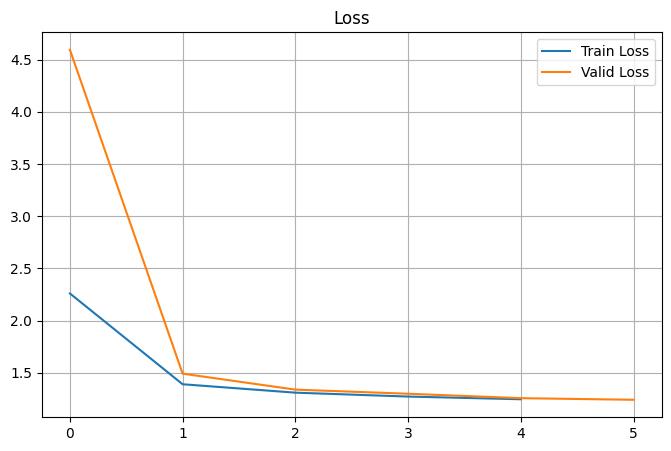

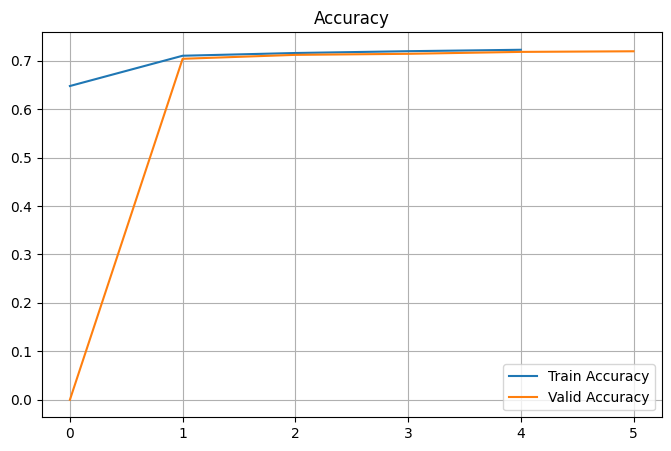

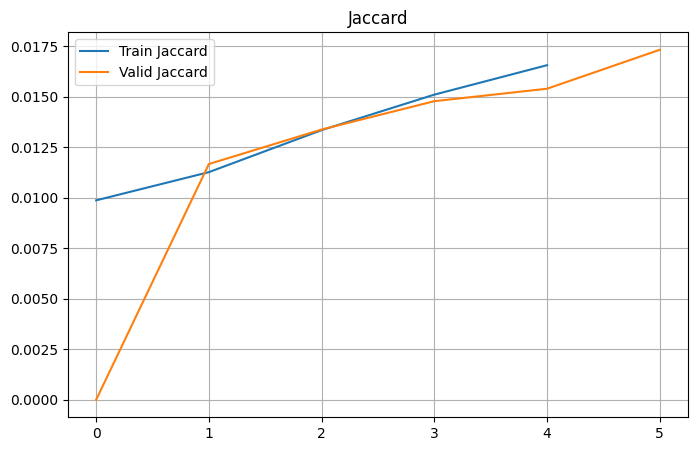

In [17]:
lightning_model = CocoLightning(model=CocoModel, lr=1e-3)
trainer = pl.Trainer(max_epochs=5, 
                     accelerator='auto') 

trainer.fit(lightning_model, train_loader, valid_loader) 
plot_stats(lightning_model.train_loss, lightning_model.valid_loss, title="Loss") 
plot_stats(lightning_model.train_accuracy, lightning_model.valid_accuracy, title= "Accuracy") 
plot_stats(lightning_model.train_iou, lightning_model.valid_iou, title="Jaccard") 


In [18]:
lightning_model.train_loss

[2.2599819, 1.389986, 1.3093351, 1.2719781, 1.2462187]

In [19]:
lightning_model.valid_loss

[4.5947876, 1.491396, 1.3384665, 1.2990628, 1.2565688, 1.2411995]